In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from util.pca import perform_pca
from util.k_folds_cross_val import k_folds_x_val, get_cmat, get_metrics
from util.hpo import gridSearchHPO
from util.forward_select import forward_select, forward_select_and_fit

from sklearn import tree   # Decision Trees
from sklearn import metrics
import sklearn as skl

# Data Loading

In [2]:
NUM_CLASSES = 6
CLASSES = ["sadnesss", "joy", "love", "anger", "fear"]

# Load all data
train_data = pd.read_csv("data/training_labse.csv")
test_data = pd.read_csv("data/test_labse.csv")
validation_data = pd.read_csv("data/validation_labse.csv")

# Separate X's and y's from each other
FEATURE_COLUMNS = [x for x in train_data if x.startswith("_e")]
LABEL_COLUMN = "label"

In [3]:
X_train = train_data[FEATURE_COLUMNS]
Y_train = train_data[LABEL_COLUMN]

X_test = test_data[FEATURE_COLUMNS]
Y_test = test_data[LABEL_COLUMN]

X_val = validation_data[FEATURE_COLUMNS]
Y_val = validation_data[LABEL_COLUMN]

# These are used to run cross validation
X_train_val = pd.concat([X_train, X_val]) 
Y_train_val = pd.concat([Y_train, Y_test])

# These are used to run val and test for Neural Nets
X_val_test = pd.concat([X_val, X_test])
Y_val_test = pd.concat([Y_val, Y_test])

# Principal Component Analysis (PCA)

In [4]:
TARGET_EXPLAINED_VARIANCE = 0.95

pca_train, X_train_reduced = perform_pca(X_train, TARGET_EXPLAINED_VARIANCE)
X_val_reduced = pca_train.transform(X_val)
X_test_reduced = pca_train.transform(X_test)
X_train_val_reduced = pca_train.transform(X_train_val)
X_val_test_reduced = pca_train.transform(X_val_test)

print(f"{pca_train.n_components_} components for training")

180 components for training


In [5]:
X_train_unreduced = X_train.to_numpy()
X_val_unreduced = X_val.to_numpy()
X_test_unreduced = X_test.to_numpy()
X_train_val_unreduced = X_train_val.to_numpy()
X_val_test_unreduced = X_val_test.to_numpy()

In [6]:
X_train_used = X_train_unreduced
X_val_used = X_val_unreduced
X_test_used = X_test_unreduced
X_train_val_used = X_train_val_unreduced 
X_val_test_used = X_val_test_unreduced

# Decision Tree Classifier

In [7]:
decision_tree_model = tree.DecisionTreeClassifier(
    criterion ='entropy', 
    splitter = 'best',
    max_depth = 256, 
    max_features = 'sqrt',
    max_leaf_nodes = 80,
)

# Grid Search Hyperparameter Optimization

In [8]:
dt_search_space = {
    # 'ccp_alpha':[0.1, 0.2, 0.4, 0.5],
    # 'min_impurity_decrease':[1.0, 0.5, 1.5, 2.0], # float
    # 'min_weight_fraction_leaf':[0.1, 0.2, 0.4, 0.5],
    # 'min_samples_leaf':[0.1, 0.2, 0.4, 0.5], 
    # 'min_samples_split':[0.1, 0.2, 0.4, 0.5],
    # 'class_weight': [],
    # 'random_state': []
    }

model_dt = decision_tree_model.fit(X_train, Y_train)

gridsearch_dt = gridSearchHPO(model=model_dt, search_space=dt_search_space)

In [9]:
gridsearch_dt.fit(X_train, Y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


GridSearchCV(cv=5, error_score='raise',
             estimator=DecisionTreeClassifier(criterion='entropy',
                                              max_depth=256,
                                              max_features='sqrt',
                                              max_leaf_nodes=80),
             n_jobs=-1, param_grid={}, scoring='accuracy', verbose=3)

In [10]:
print("Best Score: {}".format(gridsearch_dt.best_score_))
print("Best params: {}".format(gridsearch_dt.best_params_))

Best Score: 0.43131250000000004
Best params: {}


(0.448, 0.3649938643309308)


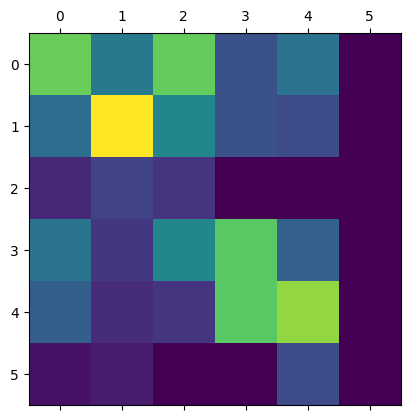

In [18]:
cmat = get_cmat(gridsearch_dt, X_test, Y_test)
print(get_metrics(gridsearch_dt, X_test, Y_test))
plt.matshow(cmat)
plt.show()

# Feature Select

In [11]:
# With feature selection
dt_fs, feature_names, X_transformed = forward_select_and_fit(gridsearch_dt, X_train, Y_train, 10, X_test, Y_test)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

In [15]:
print(f"X transformed: {X_transformed}")
print(f"Feature Names: {feature_names}")

X transformed: [[-0.00252271 -0.03674513 -0.03289624 ... -0.05495334 -0.04320653
  -0.02849178]
 [-0.0563517   0.01673299 -0.03054056 ... -0.01996989 -0.01667677
  -0.05881293]
 [ 0.00164019 -0.01943224  0.03530941 ... -0.03822707  0.01202532
  -0.0411457 ]
 ...
 [-0.037066    0.04346202  0.01950879 ... -0.0169906   0.03479575
  -0.02790003]
 [-0.03316268  0.04605081  0.04325633 ... -0.02781773  0.0195689
  -0.03908674]
 [ 0.00998093  0.02812842  0.04702408 ... -0.05821887 -0.04722942
  -0.04422961]]
Feature Names: ['_e92' '_e278' '_e279' '_e281' '_e305' '_e323' '_e363' '_e417' '_e452'
 '_e684']


In [12]:
k_folds_x_val(dt_fs, X_train, Y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Mean Accuracy: 0.429375


(0.429375,)

In [16]:
X_test_fs = X_test.loc[:, feature_names]

c:\Users\techt\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
c:\Users\techt\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


(0.46, 0.3668067402131325)


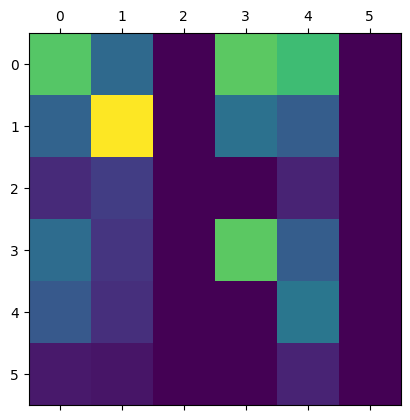

In [17]:

cmat = get_cmat(dt_fs, X_test_fs, Y_test)
print(get_metrics(dt_fs, X_test_fs, Y_test))
plt.matshow(cmat)
plt.show()